# Speaker Recognition

**Author:** Aleksej Horvat  
**Last modified:** 26/03/2021  
**Description:** Classify speakers using Fast Fourier Transform (FFT) and a 1-D Convolutional Neural Network.

## Introduction

This example demonstrates SR using a 1d CNN and Fast Fourier Tranformations and is based om the [examples](https://keras.io/guides/) in the Keras documentation. 

Notes:

- This notebooks should be run with TensorFlow 2.3 or higher.
- Resampling of the noise files requires `ffmpg`.
- Plotting requires `matplotlib`.

## Setup

If using Google Colab, data can be read from your Google Drive share and mounted using the cell below. Otherwise, point `DATASET_ROOT` in the field below to the data location.

The data used is available on [Kaggle Speaker Recognition Dataset](https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

# The data location
DATASET_ROOT = os.path.join(os.path.expanduser("~"), "/content/drive/MyDrive/16000_pcm_speeches")

# The data folders
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Train / Validation split ratio
VALID_SPLIT = 0.2

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate will be used to 
SAMPLING_RATE = 16000

# Adjust the amount of noise added
SCALE = 0.5

# Training parameters
BATCH_SIZE = 128
EPOCHS = 25


## Data preparation

The data is reorganised into 2 subfolders: `audio` and `noise`.

- An `audio` folder which will contain all the per-speaker speech sample folders
- A `noise` folder which will contain all the noise samples

In [6]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

## Noise preparation

The noise files are loaded, resampled to 1600 Hz and split into 1 second samples to match the training data.

In [7]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [8]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


## Dataset generation

In [9]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths and their labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split the data into training and validation sets
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set; the data augmentation step
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

Our class names: ['Jens_Stoltenberg', 'Julia_Gillard', 'Benjamin_Netanyau', 'Magaret_Tarcher', 'Nelson_Mandela']
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Benjamin_Netanyau
Processing speaker Magaret_Tarcher
Processing speaker Nelson_Mandela
Found 7501 files belonging to 5 classes.
Using 6001 files for training.
Using 1500 files for validation.


## Model Definition

In [10]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut to simplify the model definition by avoiding repetion
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    # Here the structure of the model is defined.
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' - stop training when the model is not enhancing anymore (affected by patience)
# 'ModelCheckPoint' - always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8000, 16)     64          input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 8000, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8000, 16)     784         activation[0][0]                 
______________________________________________________________________________________________

## Training

`model.fit()` starts the actual training, and the training history is stored from the return value. Early stopping and and model checkpoint saving callbacks are passed as parameters, and as described above.

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/25
47/47 [==============================] - 1583s 28s/step - loss: 1.3159 - accuracy: 0.6456 - val_loss: 0.3190 - val_accuracy: 0.8793
Epoch 2/25
47/47 [==============================] - 69s 1s/step - loss: 0.2983 - accuracy: 0.8825 - val_loss: 0.2022 - val_accuracy: 0.9193
Epoch 3/25
47/47 [==============================] - 69s 1s/step - loss: 0.2266 - accuracy: 0.9133 - val_loss: 0.1211 - val_accuracy: 0.9513
Epoch 4/25
47/47 [==============================] - 70s 1s/step - loss: 0.1774 - accuracy: 0.9340 - val_loss: 0.1286 - val_accuracy: 0.9547
Epoch 5/25
47/47 [==============================] - 69s 1s/step - loss: 0.1570 - accuracy: 0.9392 - val_loss: 0.4179 - val_accuracy: 0.8560
Epoch 6/25
47/47 [==============================] - 70s 1s/step - loss: 0.1860 - accuracy: 0.9293 - val_loss: 0.1086 - val_accuracy: 0.9627
Epoch 7/25
47/47 [==============================] - 69s 1s/step - loss: 0.1614 - accuracy: 0.9428 - val_loss: 0.0838 - val_accuracy: 0.9747
Epoch 8/25
47/47 

## Evaluation

Calling `model.evaluate()` on the validation set returns 

In [14]:
print(model.evaluate(valid_ds))

47/47 [==============================] - 14s 280ms/step - loss: 0.0491 - accuracy: 0.9887
[0.04913505166769028, 0.9886666536331177]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


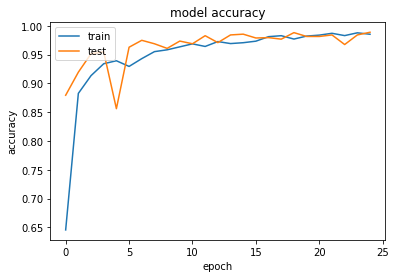

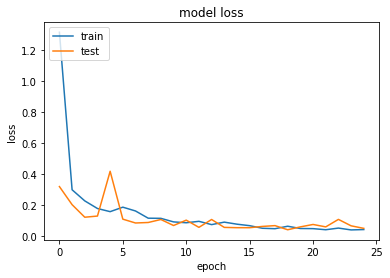

In [15]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We get ~ 98% validation accuracy.

## Demonstration

The following section returns a random sampling of entries from validation set, predicts the speaker using the trained model, and verifies the prediction using the label.

The results are shown below for manual inspection.

In [16]:
SAMPLES_TO_DISPLAY = 20

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Benjamin_Netanyau	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Julia_Gillard	Predicted: Julia_Gillard
